In [3]:
import re
import pandas as pd
import numpy as np
import datetime as dt
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
%matplotlib inline
sns.set()
sns.set_style({'ytick.bottom': True})
sns.axes_style('white')
from sklearn.model_selection import cross_val_score

In [4]:
def TrainValTest(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train_val, X_test, y_train_val, y_test = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=3)
    return X_train, X_val, X_test, y_train, y_val, y_test
    # fit linear regression to training data
        

In [84]:
with open('data/project_2_datard3.pkl', 'rb') as picklefile:
    data = pickle.load(picklefile)

In [85]:
df = pd.DataFrame(data)
df.drop_duplicates(subset = 'id',inplace=True)
df.dropna(inplace=True)

In [86]:
missed_genre_ids = df[df.genre.apply(lambda x: bool(re.search(r'\d', x)))].id
df2 = df.set_index('id').drop(labels=missed_genre_ids).reset_index()

In [87]:
df2.release_date = df2.release_date.apply(lambda x: int(x))
df2.last_sold = df2.last_sold.apply(lambda x: dt.datetime.strptime(x, '%d %b %y'))
df2.last_sold = df2.last_sold.apply(lambda x: x.toordinal())

In [105]:
df2['genre']=df2['genre'].replace('Folk, World, & Country', 'FolkWorldCountry', regex=True)

In [9]:
df2['genre'] = df2.genre.apply(lambda x: ''.join(x.split(',')[:2]))
genrecounts = df2.genre.value_counts()
othergenres = list(genrecounts[genrecounts<=60].index)
df2['genre'] = df2['genre'].replace(othergenres, 'Other')

countrycounts = df2.country.value_counts()
othercountries = list(countrycounts[countrycounts<50].index)
df2.country = df.country.replace(othercountries, 'Other')

formatcounts = df2['format'].value_counts()
otherformats = list(formatcounts[formatcounts<50].index)
df2['format'] = df2['format'].replace(otherformats, 'Other')
df2['format'].value_counts()
#df2['style'] = df2['style'].apply(lambda x: ''.join(x.split(',')[:2]))b

Vinyl       37363
CD          15556
Cassette      659
CDr           613
Other         155
DVD           121
Name: format, dtype: int64

In [10]:
df3 = df2[df2['median']<=200]

(array([2.4402e+04, 1.4628e+04, 5.8790e+03, 2.9860e+03, 1.9150e+03,
        1.0630e+03, 8.7500e+02, 5.4800e+02, 3.8000e+02, 3.5200e+02,
        2.4700e+02, 1.5600e+02, 1.6500e+02, 1.4900e+02, 7.7000e+01,
        7.2000e+01, 6.8000e+01, 4.4000e+01, 5.2000e+01, 4.8000e+01,
        3.0000e+01, 3.6000e+01, 1.7000e+01, 2.5000e+01, 3.1000e+01,
        1.1000e+01, 2.1000e+01, 2.0000e+01, 8.0000e+00, 1.7000e+01,
        8.0000e+00, 7.0000e+00, 5.0000e+00, 2.0000e+00, 8.0000e+00,
        5.0000e+00, 2.0000e+00, 8.0000e+00, 5.0000e+00, 5.0000e+00,
        0.0000e+00, 7.0000e+00, 6.0000e+00, 5.0000e+00, 4.0000e+00,
        2.0000e+00, 5.0000e+00, 1.0000e+00, 1.0000e+00, 6.0000e+00]),
 array([1.000000e-02, 4.009800e+00, 8.009600e+00, 1.200940e+01,
        1.600920e+01, 2.000900e+01, 2.400880e+01, 2.800860e+01,
        3.200840e+01, 3.600820e+01, 4.000800e+01, 4.400780e+01,
        4.800760e+01, 5.200740e+01, 5.600720e+01, 6.000700e+01,
        6.400680e+01, 6.800660e+01, 7.200640e+01, 7.600620e+01

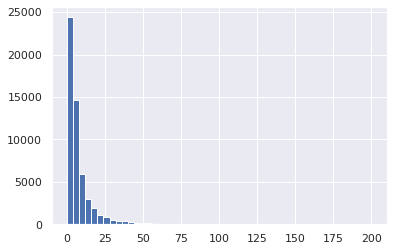

In [110]:
plt.hist(df3['median'], bins=50)

In [11]:
df_mvp = df3[['comment_num','country','format','genre',\
              'have_num','last_sold','link_num', 'num_for_sale',\
              'num_ratings','rating','release_date','want_num']]
df_mvp_target = df3['median']
df_mvp = pd.get_dummies(df_mvp)
X_tr, X_va, X_te, y_tr, y_va, y_te =\
TrainValTest(df_mvp, df_mvp_target)

In [12]:
lm = LinearRegression()
lm.fit(X_tr, y_tr)
lm.score(X_tr, y_tr)
print(np.mean(cross_val_score(lm, df_mvp, df_mvp_target, cv=5, scoring='r2')))
sorted(list(zip(X_tr.columns, lm.coef_)), key=lambda tup: abs(tup[1]), reverse = True)

0.3187395653823493


[('format_Other', 6.221707911327559),
 ('genre_Electronic Non-Music', 4.834253938633161),
 ('genre_Electronic Funk / Soul', -4.58990734499758),
 ('genre_Funk / Soul', -3.617202265917491),
 ('genre_Jazz', 3.5128389584824835),
 ('genre_Rock Blues', 3.3927896082485027),
 ('format_Vinyl', -3.32544166345418),
 ('genre_Electronic Latin', -3.2909102635877456),
 ('country_USA & Canada', -3.2025188678875725),
 ('rating', 3.0150204801872476),
 ('genre_Electronic', -2.985901889957687),
 ('country_New Zealand', -2.8846918730821196),
 ('country_Portugal', 2.8244907175544247),
 ('genre_Jazz Funk / Soul', -2.666767644449032),
 ('genre_Pop', -2.621993285919266),
 ('genre_Electronic Hip Hop', -2.609721474994792),
 ('genre_Electronic Reggae', 2.5896043086266816),
 ('format_CD', -2.5631552580672743),
 ('genre_Non-Music', 2.409491201612404),
 ('genre_Classical', 2.366037520377767),
 ('genre_Folk World', -2.2578728601239617),
 ('genre_Jazz Rock', 2.1982787820833902),
 ('genre_Funk / Soul Pop', 2.1549552875

In [13]:
poly = PolynomialFeatures()

scaler=StandardScaler()
X_tr_poly = poly.fit_transform(X_tr)
X_val_poly = poly.transform(X_va)
X_test_poly= poly.transform(X_te)

In [14]:
lm_poly = LinearRegression()
lm_poly.fit(X_tr_poly, y_tr)
print(lm_poly.score(X_tr_poly, y_tr))
cross_val_score(lm, df_mvp, df_mvp_target, cv=5, scoring='r2')

0.5163871998663061


array([0.35675012, 0.31144712, 0.32068272, 0.32676801, 0.27804986])

In [137]:
print(lm_poly.score(X_tr_poly, y_tr))

0.5163871998663061


In [15]:
alphavec = np.linspace(0.9,1.2,50)
lmlasso_poly = LassoCV(alphas=alphavec, cv=5, tol=0.01, max_iter=2000, n_jobs=3)
lmlasso_poly.fit(X_tr_poly, y_tr)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1205996.0009060954, tolerance: 43944.596457708554
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1234531.354725393, tolerance: 44057.55507270373
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1198048.7136870588, tolerance: 43776.72345099169
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1204356.5298178522, tolerance: 43944.596457708554
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196387.776269792, tolerance: 43776.72345099169
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1232929.9695727213, tolerance: 44057.55507270373
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1231711.0536739177, tolerance: 44057.55507270373
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1202989.4512770039, tolerance: 43944.596457708554
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1194993.1405789657, tolerance: 43776.72345099169
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective di

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1193809.0353095848, tolerance: 43776.72345099169
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1201708.4778549913, tolerance: 43944.596457708554
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1230391.4190311623, tolerance: 44057.55507270373
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective di

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1200467.6814431632, tolerance: 43944.596457708554
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1229212.1165157962, tolerance: 44057.55507270373
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1192522.8350265878, tolerance: 43776.72345099169
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective di

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1227894.0990534467, tolerance: 44057.55507270373
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1191212.0676548504, tolerance: 43776.72345099169
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1227761.509057094, tolerance: 44057.55507270373
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did 

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1193898.5998116967, tolerance: 43448.170221254884
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1192293.0252464237, tolerance: 42724.341864193266
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1193769.2012475214, tolerance: 43448.170221254884
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1192131.2281888116, tolerance: 43448.170221254884
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1190560.8968872642, tolerance: 42724.341864193266
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1192007.5147689572, tolerance: 43448.170221254884
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective 

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1188852.3008419503, tolerance: 42724.341864193266
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1190292.617578972, tolerance: 43448.170221254884
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1188737.720950021, tolerance: 42724.341864193266
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective di

LassoCV(alphas=array([0.9       , 0.90612245, 0.9122449 , 0.91836735, 0.9244898 ,
       0.93061224, 0.93673469, 0.94285714, 0.94897959, 0.95510204,
       0.96122449, 0.96734694, 0.97346939, 0.97959184, 0.98571429,
       0.99183673, 0.99795918, 1.00408163, 1.01020408, 1.01632653,
       1.02244898, 1.02857143, 1.03469388, 1.04081633, 1.04693878,
       1.05306122, 1.05918367, 1.06530612, 1.07142857, 1.07755102,
       1.08367...,
       1.11428571, 1.12040816, 1.12653061, 1.13265306, 1.13877551,
       1.14489796, 1.15102041, 1.15714286, 1.16326531, 1.16938776,
       1.1755102 , 1.18163265, 1.1877551 , 1.19387755, 1.2       ]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=2000,
        n_alphas=100, n_jobs=3, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.01,
        verbose=False)

0.344780412512355

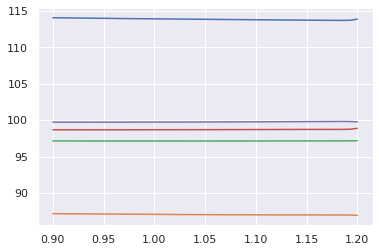

In [70]:
plt.plot(lmlasso_poly.alphas_, lmlasso_poly.mse_path_)
lmlasso_poly.score(X_val_poly, y_va)

In [74]:
sorted(list(zip(lmlasso_poly.coef_, poly.get_feature_names(X_tr.columns))), reverse=True)

[(0.05306804437750832, 'want_num genre_Electronic Pop'),
 (0.03660781191525015, 'rating want_num'),
 (0.024210610250863088, 'want_num genre_Rock'),
 (0.009476168203225272, 'have_num genre_Funk / Soul'),
 (0.008023378933589679, 'have_num genre_Electronic Funk / Soul'),
 (0.007973801088927143, 'want_num country_UK & Europe'),
 (0.007098806618438202, 'want_num country_Europe'),
 (0.006785254382415731, 'want_num genre_Rock Pop'),
 (0.005525305654490654, 'want_num genre_Electronic Rock'),
 (0.0048941816899143965, 'want_num country_US'),
 (0.004783138056135595, 'want_num country_Germany'),
 (0.004771497047541263, 'have_num genre_Rock Funk / Soul'),
 (0.004414672725059057, 'want_num country_UK'),
 (0.004393814227693774, 'num_ratings country_UK'),
 (0.0036250391291523447, 'have_num genre_Electronic'),
 (0.003495866217584574, 'have_num genre_Other'),
 (0.003193929910221138, 'have_num genre_Pop'),
 (0.0019404424085619652, 'want_num genre_Hip Hop'),
 (0.0016212636560490703, 'have_num country_Cana

In [71]:
ypred = lmlasso_poly.predict(X_val_poly)
res =y_va-ypred
res.sort_values()

18158   -192.722276
8341     -79.716060
46557    -66.101894
45271    -63.516844
49430    -61.407511
54415    -54.886041
41203    -50.963700
43389    -47.578595
38208    -43.312370
10765    -42.483704
50839    -42.447214
24705    -42.412280
54066    -40.646724
47982    -40.507421
49020    -40.200921
38617    -38.696658
12870    -37.789588
20811    -37.560354
7159     -36.955411
31012    -33.811132
49757    -31.579817
39797    -31.340361
42901    -31.081682
10001    -30.172261
21833    -30.015074
44330    -29.854834
15202    -29.237315
41284    -29.061787
15408    -29.046051
37257    -28.972093
            ...    
39807     72.520073
49078     75.412418
47292     76.781926
14793     79.772717
25571     81.520655
50399     81.943301
31076     83.754456
34043     84.525020
5896      85.727366
23774     86.903655
30479     89.740735
27223     90.350603
518       93.967669
6897      98.862797
19439    104.502559
40479    111.531385
31099    118.514822
33957    122.984431
10818    127.032996


In [61]:
wrong_pred = res.sort_values().index
ypred

array([ 4.53197829, 15.70061194,  4.96132251, ..., 20.70158026,
       21.61930962,  6.097476  ])

In [60]:
df3.loc[wrong_pred[-5:]]

,id,artist,ask_price,comment_num,country,format,format_detail,format_details,genre,have_num,...,link_num,lowest,median,num_for_sale,num_ratings,rating,release,release_date,style,want_num
37068,1134392,962971-Nu-Cru,493.41,1,NaN,Vinyl,"7""","7""",Funk / Soul,17,...,1,120.99,179.67,1,25,4.60,High Cost / Thank You Baby,1981,"Funk, Disco",175
30757,322571,Various?anv=,197.80,0,UK,Vinyl,LP,"LP, Limited Edition, Box-set",Electronic Rock,48,...,1,130.77,170.33,4,5,4.20,Noi E Il Mondo,2002,Experimental,51
29466,829870,10359-The-Verve,200.00,2,UK,Vinyl,LP,"LP, Album, Limited Edition, Blue transparent",Rock,170,...,1,79.95,200.00,2,27,4.70,Voyager 1,1993,"Space Rock, Psychedelic Rock",236
18062,1060348,346266-Activ-2,54.95,1,NaN,CD,Album,Album,Electronic,12,...,1,164.73,187.30,4,3,4.33,Everyday,2007,"Trance, Euro House, House",14
19170,521829,76971-The-New-Blockaders,210.00,0,Germany,Vinyl,LP,"LP, Limited Edition, Reissue, Remastered, Unof...",Electronic,52,...,5,137.36,199.98,2,10,4.90,The New Vortex Blockaders Campaign,1998,"Noise, Experimental",68


IndexError: index 18158 is out of bounds for axis 0 with size 10883